In [338]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from keras.layers import Dense
from keras.models import Sequential
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from tensorflow.keras.optimizers import Adam
import tensorflow_addons as tfa

In [339]:
listings_df = pd.read_csv('../data/processed/processed_listings.csv').dropna()
len(listings_df)

101364

In [340]:
listings_df.head()

,subtype,style,living_area,lot_dimensions,bedrooms,bathrooms,levels,location,listing_year,age,yard_area,listing_date,year_of_construction,price
0,2 Storey,2 storey,1191,4076,3,1,2,Capitale-Nationale,2020.0,16.0,2885,2020-12-01,2004,332500
1,Bungalow,Open area,1261,9500,2,1,1,Mauricie,2021.0,64.0,8239,2021-12-01,1957,265000
2,Townhouse,Unknown,1645,1360,3,1,3,Lachine,2021.0,15.0,0,2021-11-01,2006,612000
3,Bi-generation,Link,2024,17000,4,3,1,Capitale-Nationale,2021.0,2.0,14976,2021-12-01,2019,526500
4,Semi-detached,2 storey,2400,4471,4,2,2,Outaouais,2021.0,32.0,2071,2021-12-01,1989,360000


## Correlation Heat Map

In [341]:
sns.set_theme(style="white")

def plot_corr_map(df):
    # Compute the correlation matrix
    corr = df.corr()

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(8, 6))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

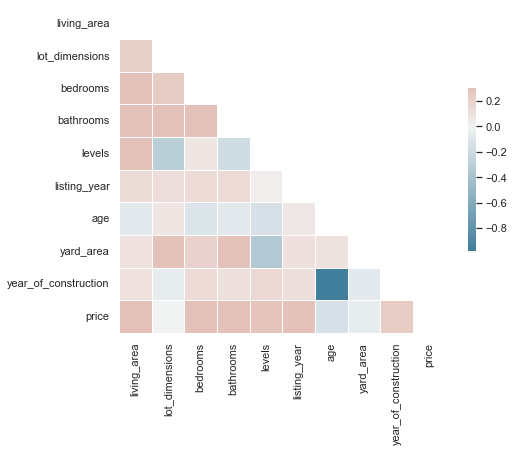

In [342]:
plot_corr_map(listings_df)

## Choosing columns

In [343]:
ordinal_cols = ['listing_year', 'age']
one_hot_cols = ['location', 'subtype']
numerical_cols = ['living_area', 'lot_dimensions', 'bedrooms', 'bathrooms', 'levels', 'yard_area']
target_col = ['price']

In [344]:
listings_df = listings_df[ordinal_cols + one_hot_cols + numerical_cols + target_col]
listings_df.head()

,listing_year,age,location,subtype,living_area,lot_dimensions,bedrooms,bathrooms,levels,yard_area,price
0,2020.0,16.0,Capitale-Nationale,2 Storey,1191,4076,3,1,2,2885,332500
1,2021.0,64.0,Mauricie,Bungalow,1261,9500,2,1,1,8239,265000
2,2021.0,15.0,Lachine,Townhouse,1645,1360,3,1,3,0,612000
3,2021.0,2.0,Capitale-Nationale,Bi-generation,2024,17000,4,3,1,14976,526500
4,2021.0,32.0,Outaouais,Semi-detached,2400,4471,4,2,2,2071,360000


## One Hot Encoding

In [345]:
def oh_encode(df_line, col, new_col, val):
    if df_line[col] == val:
        return df_line[new_col] + 1
    else:
        return df_line[new_col]

for col in one_hot_cols:
    for val in listings_df[col].unique():   
        new_col = str(val) + '_' + col
        listings_df[new_col] = 0
        listings_df[new_col] = listings_df.apply(oh_encode, args=(col, new_col, val), axis=1)

    listings_df = listings_df.drop(columns=[col])

In [346]:
listings_df.head()

,listing_year,age,living_area,lot_dimensions,bedrooms,bathrooms,levels,yard_area,price,Capitale-Nationale_location,...,St-Stanislas-De-Champlain_location,2 Storey_subtype,Bungalow_subtype,Townhouse_subtype,Bi-generation_subtype,Semi-detached_subtype,Split Level_subtype,1 1/2 Storey_subtype,Country Home_subtype,Condominium_subtype
0,2020.0,16.0,1191,4076,3,1,2,2885,332500,1,...,0,1,0,0,0,0,0,0,0,0
1,2021.0,64.0,1261,9500,2,1,1,8239,265000,0,...,0,0,1,0,0,0,0,0,0,0
2,2021.0,15.0,1645,1360,3,1,3,0,612000,0,...,0,0,0,1,0,0,0,0,0,0
3,2021.0,2.0,2024,17000,4,3,1,14976,526500,1,...,0,0,0,0,1,0,0,0,0,0
4,2021.0,32.0,2400,4471,4,2,2,2071,360000,0,...,0,0,0,0,0,1,0,0,0,0


## Spliting Data

In [347]:
y = listings_df[target_col]
X = listings_df.drop(columns=target_col)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

## Ordinal Encoding

In [348]:
ordinal_encoders = {}

for col in ordinal_cols:
    ordinal_encoders[col] = OrdinalEncoder()
    ordinal_encoders[col].fit(listings_df[[col]])
    X_train[col] = ordinal_encoders[col].transform(X_train[[col]])
    X_test[col] = ordinal_encoders[col].transform(X_test[[col]])

X_train.head()

,listing_year,age,living_area,lot_dimensions,bedrooms,bathrooms,levels,yard_area,Capitale-Nationale_location,Mauricie_location,...,St-Stanislas-De-Champlain_location,2 Storey_subtype,Bungalow_subtype,Townhouse_subtype,Bi-generation_subtype,Semi-detached_subtype,Split Level_subtype,1 1/2 Storey_subtype,Country Home_subtype,Condominium_subtype
64500,17.0,20.0,1191,4076,3,1,2,2885,1,0,...,0,1,0,0,0,0,0,0,0,0
66201,18.0,50.0,1267,10100,4,2,1,8833,0,0,...,0,0,0,0,1,0,0,0,0,0
42369,10.0,48.0,1100,9100,2,1,1,8000,0,0,...,0,0,1,0,0,0,0,0,0,0
16454,16.0,74.0,1995,4999,5,2,2,3004,0,0,...,0,1,0,0,0,0,0,0,0,0
9377,17.0,26.0,739,3229,3,1,1,2490,0,0,...,0,0,0,0,0,1,0,0,0,0


## Scaling

In [349]:
scaled_cols = numerical_cols + ordinal_cols

In [350]:
scalers = {}

for col in scaled_cols:
    scalers[col] = MinMaxScaler()
    X_train[col] = scalers[col].fit_transform(X_train[[col]])
    X_test[col] = scalers[col].transform(X_test[[col]])

In [351]:
scale_target = True

if scale_target:
    target_scaler = MinMaxScaler()

    y_train = target_scaler.fit_transform(y_train)
    y_test = target_scaler.fit_transform(y_test)

X_train.head()

,listing_year,age,living_area,lot_dimensions,bedrooms,bathrooms,levels,yard_area,Capitale-Nationale_location,Mauricie_location,...,St-Stanislas-De-Champlain_location,2 Storey_subtype,Bungalow_subtype,Townhouse_subtype,Bi-generation_subtype,Semi-detached_subtype,Split Level_subtype,1 1/2 Storey_subtype,Country Home_subtype,Condominium_subtype
64500,0.894737,0.094059,0.198677,0.191644,0.4,0.000000,0.5,0.150558,1,0,...,0,1,0,0,0,0,0,0,0,0
66201,0.947368,0.242574,0.220529,0.497462,0.6,0.333333,0.0,0.460964,0,0,...,0,0,0,0,1,0,0,0,0,0
42369,0.526316,0.232673,0.172513,0.446695,0.2,0.000000,0.0,0.417493,0,0,...,0,0,1,0,0,0,0,0,0,0
16454,0.842105,0.361386,0.429845,0.238501,0.8,0.333333,0.5,0.156769,0,0,...,0,1,0,0,0,0,0,0,0,0
9377,0.894737,0.123762,0.068718,0.148645,0.4,0.000000,0.0,0.129945,0,0,...,0,0,0,0,0,1,0,0,0,0


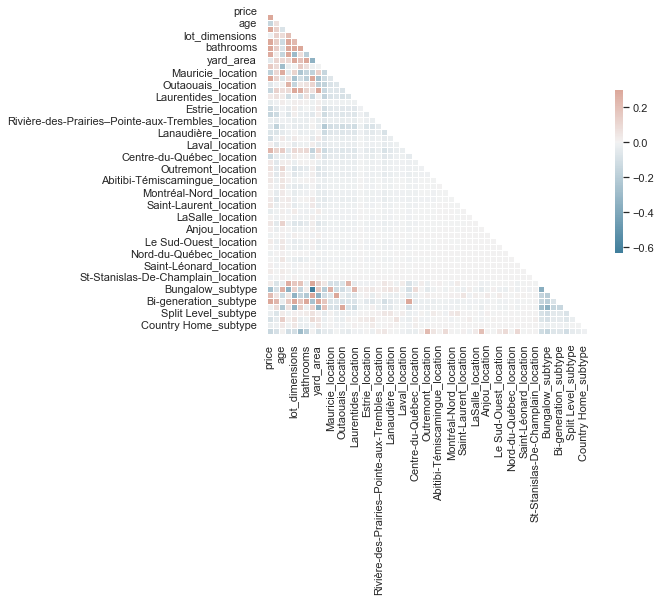

In [352]:
df = X_train.copy()
df.insert(0, 'price', y_train)
plot_corr_map(df)

In [353]:
reg = LinearRegression().fit(X_train, y_train)
reg.score(X_test, y_test)

0.6929540852991738

# Neural Net

In [354]:
model = Sequential()
model.add(Dense(units=20, activation='tanh', input_shape=(X_train.shape[-1],)))
model.add(Dense(units=10, activation='tanh'))
model.add(Dense(units=1, activation='linear'))

print(model.summary())

model.compile(optimizer=Adam(lr=0.001), loss='mse')

history = model.fit(X_train, y_train, batch_size=1000, epochs=500, shuffle=True, verbose=1, validation_data=(X_test, y_test))

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_70 (Dense)            (None, 20)                1080      
                                                                 
 dense_71 (Dense)            (None, 10)                210       
                                                                 
 dense_72 (Dense)            (None, 1)                 11        
                                                                 
Total params: 1,301
Trainable params: 1,301
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500


c:\Users\simon\Documents\GitHub\quebec-real-estate\venv\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


77/77 [==============================] - 0s 2ms/step - loss: 0.0644 - val_loss: 0.0186
Epoch 2/500
77/77 [==============================] - 0s 1ms/step - loss: 0.0121 - val_loss: 0.0102
Epoch 3/500
77/77 [==============================] - 0s 1ms/step - loss: 0.0081 - val_loss: 0.0084
Epoch 4/500
77/77 [==============================] - 0s 1ms/step - loss: 0.0070 - val_loss: 0.0077
Epoch 5/500
77/77 [==============================] - 0s 1ms/step - loss: 0.0064 - val_loss: 0.0072
Epoch 6/500
77/77 [==============================] - 0s 1ms/step - loss: 0.0061 - val_loss: 0.0069
Epoch 7/500
77/77 [==============================] - 0s 1ms/step - loss: 0.0059 - val_loss: 0.0067
Epoch 8/500
77/77 [==============================] - 0s 1ms/step - loss: 0.0058 - val_loss: 0.0067
Epoch 9/500
77/77 [==============================] - 0s 1ms/step - loss: 0.0057 - val_loss: 0.0067
Epoch 10/500
77/77 [==============================] - 0s 1ms/step - loss: 0.0056 - val_loss: 0.0066
Epoch 11/500
77/77 [=

In [355]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

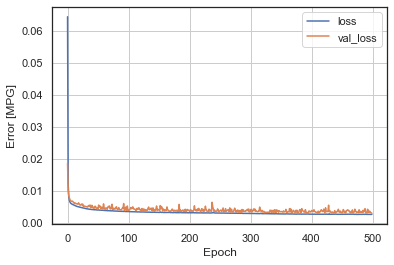

In [356]:
plot_loss(history)

In [357]:
sk_predicted_prices = target_scaler.inverse_transform(reg.predict(X_test))
nnet_predicted_prices = target_scaler.inverse_transform(model.predict(X_test))
real_prices = target_scaler.inverse_transform(y_test)

In [358]:
test_df = X_test.copy()

In [359]:
for col in scaled_cols:
    test_df[col] = scalers[col].inverse_transform(test_df[[col]])

for col in ordinal_cols:
    test_df[col] = ordinal_encoders[col].inverse_transform(test_df[[col]])

In [360]:
d = {}
d['real price'] = list(real_prices)
d['nnet predicted price'] = list(nnet_predicted_prices)
d['sk predicted price'] = list(sk_predicted_prices)

test_df['real price'] = d['real price']
test_df['nnet predicted price'] = d['nnet predicted price']
test_df['sk predicted price'] = d['sk predicted price']

test_df['real price'] = test_df['real price'].astype(int)
test_df['nnet predicted price'] = test_df['nnet predicted price'].astype(int)
test_df['sk predicted price'] = test_df['sk predicted price'].astype(int)

In [361]:
test_df.head(12)

,listing_year,age,living_area,lot_dimensions,bedrooms,bathrooms,levels,yard_area,Capitale-Nationale_location,Mauricie_location,...,Townhouse_subtype,Bi-generation_subtype,Semi-detached_subtype,Split Level_subtype,1 1/2 Storey_subtype,Country Home_subtype,Condominium_subtype,real price,nnet predicted price,sk predicted price
69400,2020.0,16.0,1191.0,4076.0,3.0,1.0,2.0,2885.0,1,0,...,0,0,0,0,0,0,0,332500,336317,384807
83068,2021.0,32.0,960.0,6157.0,3.0,2.0,1.0,5197.0,0,0,...,0,0,0,0,0,0,0,400000,383977,390985
39735,2015.0,49.0,1034.0,6929.0,3.0,1.0,1.0,5895.0,0,0,...,0,0,0,0,0,0,0,199999,239618,258314
46260,2013.0,9.0,1120.0,2500.0,2.0,1.0,2.0,1380.0,0,0,...,1,0,0,0,0,0,0,214999,250980,259663
50156,2011.0,136.0,1682.0,6180.0,3.0,1.0,2.0,4498.0,0,0,...,0,0,0,0,0,0,0,670000,494485,295698
100364,2013.0,87.0,792.0,435.0,2.0,1.0,3.0,0.0,0,0,...,0,0,0,0,0,0,1,242500,304334,425897
32456,2015.0,31.0,826.0,4038.0,3.0,2.0,1.0,3212.0,0,0,...,0,0,0,0,0,0,0,270000,248011,319640
2218,2021.0,29.0,1180.0,11400.0,3.0,2.0,1.0,10220.0,0,0,...,0,0,0,0,0,0,0,310000,423265,376304
82213,2021.0,15.0,1645.0,1360.0,3.0,1.0,3.0,0.0,0,0,...,1,0,0,0,0,0,0,612000,614606,588719
2012,2021.0,11.0,1205.0,7200.0,4.0,2.0,1.0,5995.0,0,0,...,0,0,0,0,0,0,0,310000,301492,317145


In [362]:
errors = abs(nnet_predicted_prices - real_prices)
errors_small = list(filter(lambda x: x < 100000, errors))
errors_pct = 100 * (abs(nnet_predicted_prices - real_prices) / real_prices)
errors_pct_small = list(filter(lambda x: x < 100, errors_pct))

c:\Users\simon\Documents\GitHub\quebec-real-estate\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

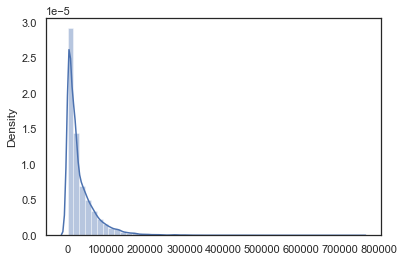

In [363]:
sns.distplot(errors)

c:\Users\simon\Documents\GitHub\quebec-real-estate\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

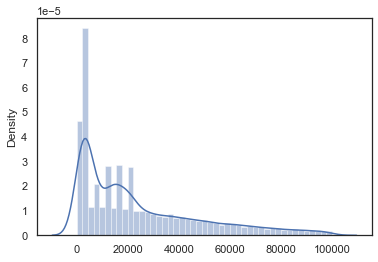

In [364]:
sns.distplot(errors_small)

c:\Users\simon\Documents\GitHub\quebec-real-estate\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

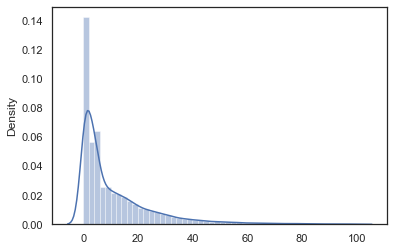

In [365]:
sns.distplot(errors_pct_small)

In [366]:
e_avg = int(np.mean(errors))
e_std = int(np.std(errors))
epct_avg = round(np.mean(errors_pct), 2)
epct_std = round(np.std(errors_pct), 2)

print('Error Mean ($): ' + str(e_avg) + '$')
print('Error std ($): ' + str(e_std) + '$')
print('Error Mean (%): ' + str(epct_avg) + '%')
print('Error std (%): ' + str(epct_std) + '%')

Error Mean ($): 31984$
Error std ($): 40691$
Error Mean (%): 12.46%
Error std (%): 19.07%
